In [1]:
import pandas as pd
import subprocess
import sys
import matplotlib.pyplot as plt
from matplotlib import cm 
import numpy as np
import os
import shutil

#local imports
from gwas.qc import QC
from gwas.utils import shell_do, merge_genos, ld_prune, random_sample_snps, flash_pca, plot_pcs

In [2]:
structure = 'fastStructure/structure.py'
# geno_name = '/data/vitaled2/test_data/spanish_gwas2/SPAIN2ndpart_pheno'
# out_path = '/data/vitaled2/test_data/spanish_gwas2/'
# geno_name = '/data/vitaled2/test_data/FIN/PD.FIN'
# out_path = '/data/vitaled2/test_data/FIN/'
geno_name = '/data/vitaled2/test_data/mcgill/MCGILL_all'
out_path = '/data/vitaled2/test_data/mcgill'

ref_dir_path = f'/data/LNG/vitaled2/1kgenomes'
ref_panel = f'{ref_dir_path}/1kg_ashkj_ref_panel_gp2_pruned'


# demographic info
ref_dir_path = f'/data/LNG/vitaled2/1kgenomes'
ashk_data = f'/data/LNG/iwakih2/dataset/Jew/GSE23636'
onekg_demog_path = f'{ref_dir_path}/igsr_samples.tsv'
ancestry_file = f'{ref_dir_path}/ref_panel_ancestry.txt'

In [3]:
# now make filenames:
geno_call_rate = geno_name + "_call_rate"
geno_sex = geno_call_rate + "_sex"
geno_het =  geno_sex + "_het"


In [4]:
# # INSTANTIATE QC WITH INPUT NAME AND OUTPUT NAME     
qc = QC(geno_name, rare=False)

# NOW RUN COMMANDS
# FIRST, CLEAR EXISTING LOGFILE
qc.rm_log()

# run het pruning
qc.call_rate_pruning(geno_name)
qc.sex_check(geno_call_rate)
qc.het_pruning(geno_sex)

PROCESSING THE FOLLOWING GENOTYPES: /data/vitaled2/test_data/mcgill/MCGILL_all

PRUNING FOR CALL RATE
logging to /data/vitaled2/test_data/mcgill/MCGILL_all.PLINK_STEPS.log
***********************************************

CHECKING SEXES
logging to /data/vitaled2/test_data/mcgill/MCGILL_all.PLINK_STEPS.log
***********************************************

PRUNING FOR HETEROZYGOSITY
logging to /data/vitaled2/test_data/mcgill/MCGILL_all.PLINK_STEPS.log
***********************************************



In [5]:
# keep this for now, but eventually should be a function

geno_ancestry_prune1 = f'{geno_het}_ancestry_prune1'
geno_ancestry_prune2 = f'{geno_het}_ancestry_prune2'
# geno_ancestry_prune3 = f'{geno_het}_ancestry_prune3'

# prune geno_het for geno, maf, hwe, and palindromes
geno_het_bim = pd.read_csv(f'{geno_het}.bim', sep='\t', header=None)

# find and drop palindromes in geno_het bim file
geno_het_bim.columns = ['chr', 'rsid', 'kb', 'pos', 'a1', 'a2']
palindromes = geno_het_bim.loc[((geno_het_bim.a1 == 'A') & (geno_het_bim.a2 == 'T')) | ((geno_het_bim.a1 == 'T') & (geno_het_bim.a2 == 'A')) | ((geno_het_bim.a1 == 'C') & (geno_het_bim.a2 == 'G')) | ((geno_het_bim.a1 == 'G') & (geno_het_bim.a2 == 'C'))]
palindromes['rsid'].to_csv(f'{geno_het}_palindromes.snplist', header=False, index=False, sep='\t')

plink_cmd1 = f'plink --bfile {geno_het}\
 --maf 0.05\
 --geno 0.01\
 --hwe 0.0001\
 --autosome\
 --allow-no-sex\
 --exclude {geno_het}_palindromes.snplist\
 --make-bed\
 --out {geno_ancestry_prune1}' 

#remove high-LD regions
plink_cmd2 = f'plink --bfile {geno_ancestry_prune1}\
 --exclude range {ref_dir_path}/hg19_exclusion_regions.txt\
 --autosome\
 --allow-no-sex\
 --make-bed\
 --out {geno_ancestry_prune2}'

cmds = [plink_cmd1, plink_cmd2]

for cmd in cmds:
    shell_do(cmd)
    
# prune for LD
# ld_prune(geno_ancestry_prune2, geno_ancestry_prune3)


Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het --maf 0.05 --geno 0.01 --hwe 0.0001 --autosome --allow-no-sex --exclude /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_palindromes.snplist --make-bed --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune1
Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune1 --exclude range /data/LNG/vitaled2/1kgenomes/hg19_exclusion_regions.txt --autosome --allow-no-sex --make-bed --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2


In [6]:
# now get common snps between pruned ref panel and pruned geno
geno_pruned_bim = pd.read_csv(f'{geno_ancestry_prune2}.bim', sep='\t', header=None)
geno_pruned_bim.columns = ['chr', 'rsid', 'kb', 'pos', 'a1', 'a2']
ref_bim = pd.read_csv(f'{ref_panel}.bim', sep='\t', header=None)
ref_bim.columns = ['chr', 'rsid', 'kb', 'pos', 'a1', 'a2']

common_snps = ref_bim.merge(geno_pruned_bim, how='inner', on=['rsid'])

common_snps['rsid'].to_csv(f'{out_path}/geno_ref_panel_common.snps', sep='\t', header=False, index=False)



In [7]:
# now, run pca on ref panel for snps in common with geno
ref_panel_common_snps = f'{out_path}/ref_panel_common_snps'
common_snps = f'{out_path}/geno_ref_panel_common.snps'
ext_snps_cmd = f'plink --bfile {ref_panel} --extract {common_snps} --make-bed --out {ref_panel_common_snps}'
shell_do(ext_snps_cmd)

# run pca
flash_pca(ref_panel_common_snps, ref_panel_common_snps)

Executing: plink --bfile /data/LNG/vitaled2/1kgenomes/1kg_ashkj_ref_panel_gp2_pruned --extract /data/vitaled2/test_data/mcgill/geno_ref_panel_common.snps --make-bed --out /data/vitaled2/test_data/mcgill/ref_panel_common_snps
Executing: flashpca --bfile /data/vitaled2/test_data/mcgill/ref_panel_common_snps -d 8 --outpc /data/vitaled2/test_data/mcgill/ref_panel_common_snps.pcs --outvec /data/vitaled2/test_data/mcgill/ref_panel_common_snps.vec --outval /data/vitaled2/test_data/mcgill/ref_panel_common_snps.val --outpve /data/vitaled2/test_data/mcgill/ref_panel_common_snps.pve --outload /data/vitaled2/test_data/mcgill/ref_panel_common_snps.loadings --outmeansd /data/vitaled2/test_data/mcgill/ref_panel_common_snps.meansd


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

EAS    504
AFR    504
SAS    489
AJ     471
EUR    404
AMR    347
AAC    157
FIN     99
Name: label, dtype: int64


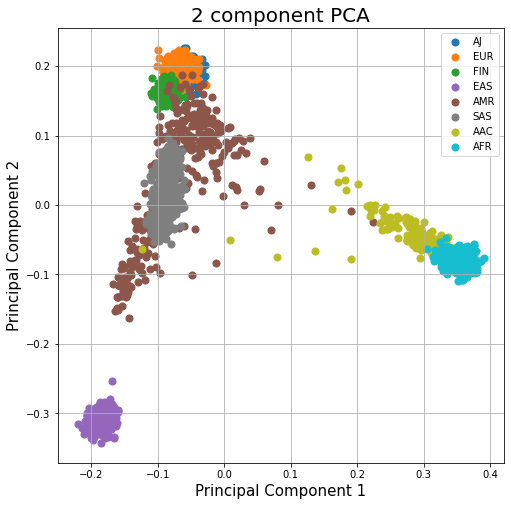

In [8]:
# read ancestry file
ancestry = pd.read_csv('/data/LNG/vitaled2/1kgenomes/ref_panel_ancestry.txt', sep='\t')
ref_fam = pd.read_csv(f'{ref_panel}.fam', sep=' ', header=None)
ref_labeled = ref_fam.merge(ancestry, how='left', left_on=[0,1], right_on=['FID','IID'])

pca = pd.read_csv(f'{ref_panel_common_snps}.pcs', sep='\t')

# combined_labels
labeled_pca = pca.merge(ref_labeled, how='left', on=['FID','IID'])
labeled_pca.drop(columns=[0,1,2,3,4,5],inplace=True)
print(labeled_pca.label.value_counts())
# plot it!
plot_pcs(labeled_pca)

In [9]:
# get reference alleles from ref_panel_common_snps
ref_panel_common_snps_ref_alleles = f'{ref_panel_common_snps}.ref_allele'
ref_panel_common_snps_bim = pd.read_csv(f'{ref_panel_common_snps}.bim', header=None, sep='\t')
ref_panel_common_snps_bim.columns = ['chr', 'rsid', 'kb', 'pos', 'a1', 'a2']
ref_panel_common_snps_bim[['rsid','a1']].to_csv(ref_panel_common_snps_ref_alleles, sep='\t', header=False, index=False)

In [10]:
geno_common_snps = f'{geno_ancestry_prune2}_common_snps'

ext_snps_cmd = f'plink --bfile {geno_ancestry_prune2} --extract {common_snps} --reference-allele {ref_panel_common_snps_ref_alleles} --make-bed --out {geno_common_snps}'
shell_do(ext_snps_cmd)

Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2 --extract /data/vitaled2/test_data/mcgill/geno_ref_panel_common.snps --reference-allele /data/vitaled2/test_data/mcgill/ref_panel_common_snps.ref_allele --make-bed --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_common_snps


In [11]:
project_geno_pcs_cmd = f'flashpca --bfile {geno_common_snps}\
 --project\
 --inmeansd\
 {ref_panel_common_snps}.meansd\
 --outproj {geno_common_snps}.projections\
 --inload {ref_panel_common_snps}.loadings\
 -v'

shell_do(project_geno_pcs_cmd)
# print(project_geno_pcs_cmd)

Executing: flashpca --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_common_snps --project --inmeansd /data/vitaled2/test_data/mcgill/ref_panel_common_snps.meansd --outproj /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_common_snps.projections --inload /data/vitaled2/test_data/mcgill/ref_panel_common_snps.loadings -v


In [27]:
projected = pd.read_csv(f'{geno_common_snps}.projections', sep='\t')
projected['label'] = 'new'
total_pca = labeled_pca.append(projected)


,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,label
0,AJ,1A2,-0.081866,0.202276,-0.032451,0.067536,0.082021,-0.004461,-0.014771,0.003977,AJ
1,AJ,1A3,-0.055714,0.182318,-0.031472,0.056675,0.098907,-0.005778,-0.021555,-0.011962,AJ
2,AJ,1A5,-0.060500,0.226522,-0.032951,0.088775,0.124442,0.019479,-0.041475,-0.008812,AJ
3,AJ,1A6,-0.046325,0.207300,-0.024395,0.055186,0.085453,-0.008589,-0.020816,0.015212,AJ
4,AJ,1A8,-0.046389,0.177595,-0.032404,0.063480,0.084394,-0.015591,-0.026968,0.012325,AJ
...,...,...,...,...,...,...,...,...,...,...,...
2361,CEPH-1334,NA12146,-0.060862,0.175638,-0.019143,0.024342,-0.063812,-0.017221,-0.012467,0.012442,new
2362,CEPH-1334,NA12239,-0.068274,0.149561,-0.030637,0.023234,-0.075129,0.003473,-0.016081,0.009250,new
2363,CEPH-1408,NA10830,-0.061973,0.160249,-0.018466,0.035719,-0.083846,0.005005,-0.015302,0.002239,new
2364,CEPH-1408,NA12154,-0.049287,0.151205,-0.024470,0.024935,-0.085320,-0.020427,-0.009072,-0.014955,new


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

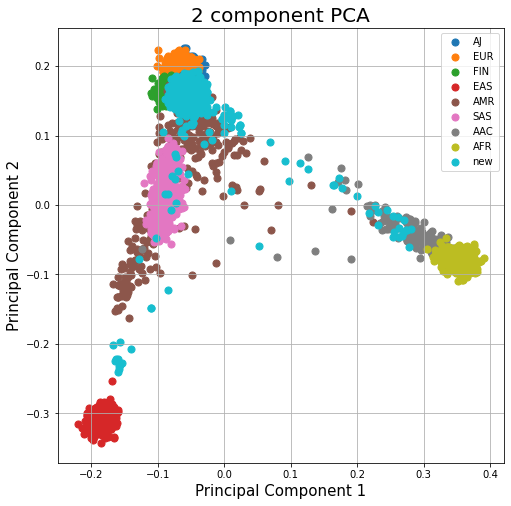

In [13]:
plot_pcs(total_pca)

In [34]:
# now merge ref and geno and run faststructure
merged_ref_geno = f'{geno_ancestry_prune2}_merged_ref'
total_pca[['FID', 'IID', 'label']].to_csv(f'{merged_ref_geno}.labels', sep='\t')
merge_genos(geno_common_snps, ref_panel_common_snps, merged_ref_geno)

Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_common_snps --allow-no-sex --bmerge /data/vitaled2/test_data/mcgill/ref_panel_common_snps --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref --make-bed
Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_common_snps --allow-no-sex --flip /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref-merge.missnp --make-bed --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_common_snps_flip
Executing: plink --bfile /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_common_snps_flip --allow-no-sex --bmerge /data/vitaled2/test_data/mcgill/ref_panel_common_snps --out /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref_flip --make-bed


In [38]:
# Now, test with faststructure
ancestry_labels = f'{merged_ref_geno}.labels'
structure_out = f'{merged_ref_geno}_structure'
# fam = pd.read_csv(f'{ref_panel_prune_final}.fam', sep=' ', header=None)
structure = f'/data/vitaled2/ref_panel/fastStructure/structure.py'


# run for k=1-8 and use chooseK.py to select best
fs_swarm_script = f'{out_path}/faststructure_choosek.swarm'
with open(fs_swarm_script, 'w') as f:
    for k in range(1,9):
        fs_cmd = f'bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i {merged_ref_geno} -o {structure_out} -f {structure} -k {k}'
        f.write(f'{fs_cmd}\n')
    f.close()

shell_do(f'swarm -f {fs_swarm_script} -g 16 --time=10:00:00 -t 20 --logdir {ref_dir_path}/swarm --partition=norm')

Executing: swarm -f /data/vitaled2/test_data/mcgill/faststructure_choosek.swarm -g 16 --time=10:00:00 -t 20 --logdir /data/LNG/vitaled2/1kgenomes/swarm --partition=norm


In [37]:
!cat {fs_swarm_script}

bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref -o /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref_structure -f /data/vitaled2/ref_panel/fastStructure/structure.py -k 1
bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref -o /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref_structure -f /data/vitaled2/ref_panel/fastStructure/structure.py -k 2
bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh -i /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref -o /data/vitaled2/test_data/mcgill/MCGILL_all_call_rate_sex_het_ancestry_prune2_merged_ref_structure -f /data/vitaled2/ref_panel/fastStructure/structure.py -k 3
bash /data/vitaled2/GWAS/gwas/faststructure_setup_and_run.sh 

2366


2975


5341

In [33]:
!head {merged_ref_geno}.labels

,FID,IID,label
0,AJ,1A2,AJ
1,AJ,1A3,AJ
2,AJ,1A5,AJ
3,AJ,1A6,AJ
4,AJ,1A8,AJ
5,AJ,1A12,AJ
6,AJ,1B2,AJ
7,AJ,1B3,AJ
8,AJ,1B5,AJ
